In [1]:
import nltk
from nltk.corpus import brown
from sklearn.svm import SVC
import numpy as np
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.feature_extraction import DictVectorizer
from tqdm import tqdm
from matplotlib import pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (20,10)
pylab.rc('xtick', labelsize=18) 
pylab.rc('ytick', labelsize=18) 
pylab.rc('title', labelsize=25)

C:\Users\Matteo\Anaconda3\envs\py35\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Populating the interactive namespace from numpy and matplotlib


KeyError: 'Unrecognized key "title.labelsize" for group "title" and name "labelsize"'

In [ ]:
n_sents = len(brown.tagged_sents())
tag_set = 'universal'
len_train = int(n_sents * 0.9)
len_test = n_sents - len_train
len_train = 5000
train_set, test_set = brown.tagged_sents(tagset = tag_set)[:len_train],\
                        brown.tagged_sents(tagset = tag_set)[-len_test:] 
sentences, train_sentences, test_sentences = brown.sents(), brown.sents()[:len_train], brown.sents()[-len_test:] 
print('Number of sentences: {}'.format(n_sents))
print('Train set Length: {}'.format(len(train_set)))
print('Test set Length: {}'.format(len(test_set)))

In [4]:
emit = defaultdict(int)
transition = defaultdict(int)
context = defaultdict(int)
for sentence in train_set:
    previous = '<s>'
    context[previous] += 1
    for word in sentence:
        emit[word] += 1
        transition[(previous, word[1])] += 1
        previous = word[1]
        context[word[1]] += 1

In [5]:
prob_emit = defaultdict(float)
prob_trans = defaultdict(float)

for key in transition.keys():
    previous_tag = key[0]
    prob_trans[key] = transition[key] / context[previous_tag]

for key in emit.keys():
    tag = key[1]
    prob_emit[key] = emit[key] / context[tag]

In [6]:
#Troppo lento, sarebbe meglio creare la struttura tags of word prima, forse
def tag_sentence(sentence):
    prod = 1
    previous = '<s>'
    tagged_sentence = []
    for word in sentence:
        tags_of_word = []
        probs = []
        for key in prob_emit:
            if key[0] == word:
                tags_of_word.append(key[1])
        temp_prod = 0
        if len(tags_of_word) != 0:
            for possible_tag in tags_of_word:
                temp_prod = prod * prob_emit[(word,possible_tag)] * prob_trans[(previous, possible_tag)] 
                probs.append(temp_prod)
        else:
            tags_of_word = list(context.keys() - '.')
            for possible_tag in tags_of_word:
                temp_prod = prod * prob_trans[(previous, possible_tag)] 
                probs.append(temp_prod)
        prod = np.max(probs)
        selected_tag = tags_of_word[np.argmax(probs)] 
        tagged_sentence.append((word, selected_tag))
        previous = selected_tag
    return tagged_sentence

In [7]:
def tag_sentences(sentences):
    tagged_sentences = []
    for sentence in sentences:
        tagged_sentences.append(tag_sentence(sentence))
    return tagged_sentences

In [8]:
def accuracy(HMM_tagged_test_set, test_set):
    correct = 0
    total_count = 0
    for r in range(len(HMM_tagged_test_set)):
        for c in range(len(HMM_tagged_test_set[r])):
            total_count += 1
            if(HMM_tagged_test_set[r][c][1] == test_set[r][c][1]):
                correct+=1
    return (correct/total_count)*100

In [10]:
HMM_tagged_sentences = tag_sentences(test_sentences)

In [11]:
corr_dict = defaultdict(int)
wrong_dict = defaultdict(int)

for i in range(len(test_set)):
    for j in range(len(test_set[i])):
        if(test_set[i][j][1] == HMM_tagged_sentences[i][j][1]):
            corr_dict[test_set[i][j][1]] += 1
        else:
            wrong_dict[test_set[i][j][1]] += 1

In [14]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
tags_plot = ['NOUN','NUM','CONJ','DET','VERB','PRT','ADV','PRON','ADP','ADJ','.','X']

golds = [tag for sentence in test_set for _,tag in sentence]
HMM_tagger_pred_labels = [tag for sentence in HMM_tagged_sentences for _,tag in sentence]

cm = confusion_matrix(golds, HMM_tagger_pred_labels,labels=tags_plot)

Normalized confusion matrix


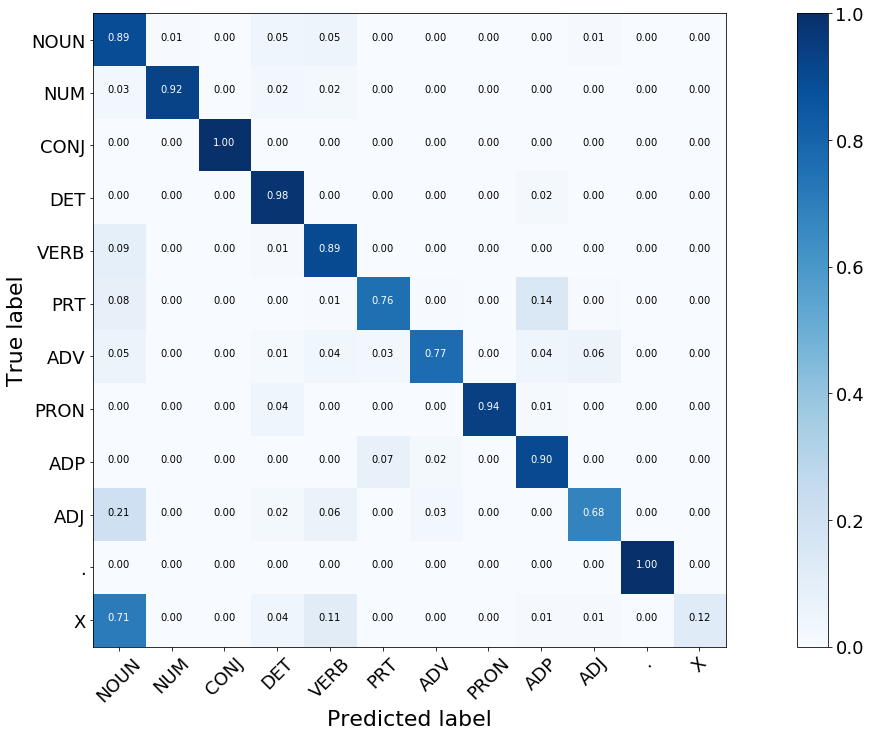

In [15]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=22)
    plt.xlabel('Predicted label', fontsize=22)

plot_confusion_matrix(cm, tags_plot,normalize=True)
plt.savefig('HMM_CM_{}_{}_train_sentences.png'.format(tag_set,len_train), bbox_inches="tight", transparent = True)

In [16]:
out = open('HMM_metrics_{}_{}_train_sentences.txt'.format(tag_set,len_train),'w')
#Calculate metrics for each label, and find their average, weighted by support 
#(the number of true instances for each label). 
#This alters ‘macro’ to account for label imbalance; it can result in an F-score 
#that is not between precision and recall.
out.write(" Accuracy: {}\n".format(metrics.accuracy_score(golds,HMM_tagger_pred_labels)))

#ability of the classifier not to label as positive a sample that is negative
out.write(" Precision: {}\n".format(metrics.precision_score(golds,HMM_tagger_pred_labels, average='weighted')))

#ability of the classifier to find all the positive samples.
out.write(" Recall: {}\n".format(metrics.recall_score(golds,HMM_tagger_pred_labels,average='weighted')))

out.write(" F1-Score: {}\n".format(metrics.f1_score(golds,HMM_tagger_pred_labels,average='weighted')))
out.close()

In [17]:
hist = []
for tag in tags_plot:
    hist.append([corr_dict.get(tag,0), wrong_dict.get(tag,0)])

C:\Users\Matteo\Anaconda3\envs\py35\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


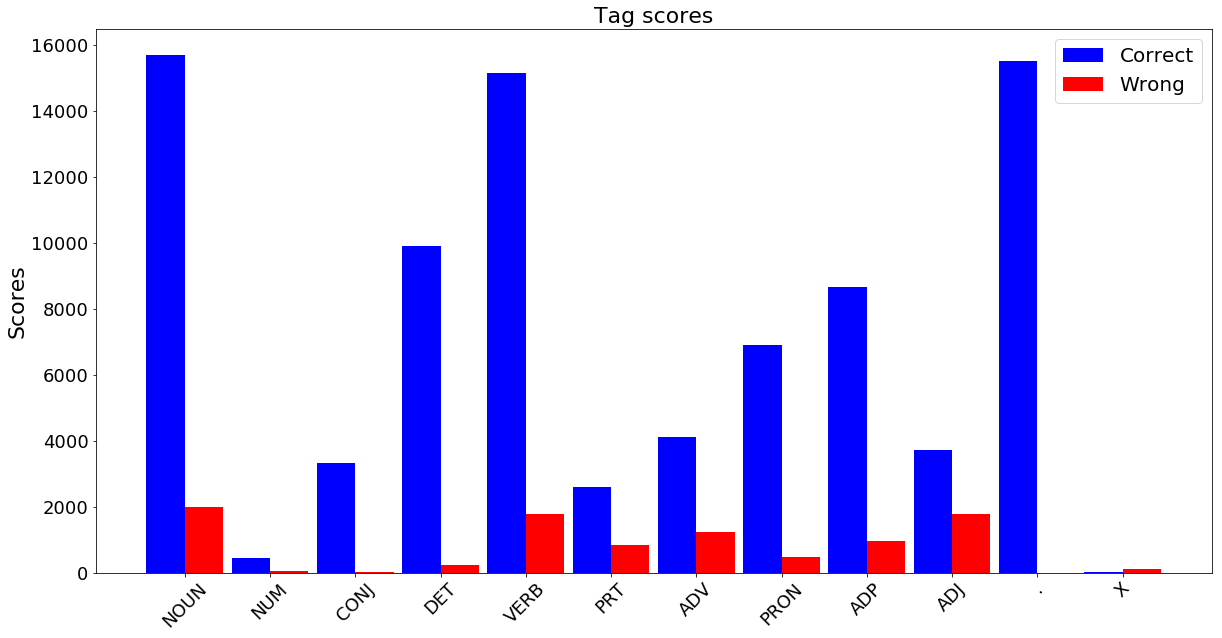

In [18]:
plt.clf()
x_labels = tags_plot
width = 0.45
fig, ax = plt.subplots()
range_bar1 = np.arange(len(x_labels))
rects1 = ax.bar(range_bar1, tuple(np.array(hist)[:,0]) , width, color='b')
rects2 = ax.bar(range_bar1 + width, tuple(np.array(hist)[:,1]) , width, color='r')

ax.set_ylabel('Scores',fontsize=22)
ax.set_title('Tag scores', fontsize=22)
ax.set_xticks(range_bar1 + width/2)
ax.set_xticklabels(x_labels)

ax.legend((rects1[0], rects2[0]), ('Correct', 'Wrong'),fontsize=20)
plt.legend()
plt.xticks(rotation=45)
plt.savefig('HMM_accuracy_bars_{}_{}_train_sentences.png'.format(tag_set,len_train), bbox_inches="tight", transparent = True)
plt.show()